
Manual Parameters:
mu = 0.00001, beta = 0.16746, gamma = 0.03000, c1 = 2.00000, c2 = 0.21000, c3 = 5.60000, K = 0.50000

Validation Metrics:
RMSE for Rushed Feeling: 0.2086
RMSE for Worry: 0.2873
R² for Rushed Feeling: 0.6446
R² for Worry: 0.4636
Pearson r (N): 0.865 (p=0.026)
Pearson r (P): 0.717 (p=0.109)

DTW distance (N): 0.538
DTW distance (P): 0.946


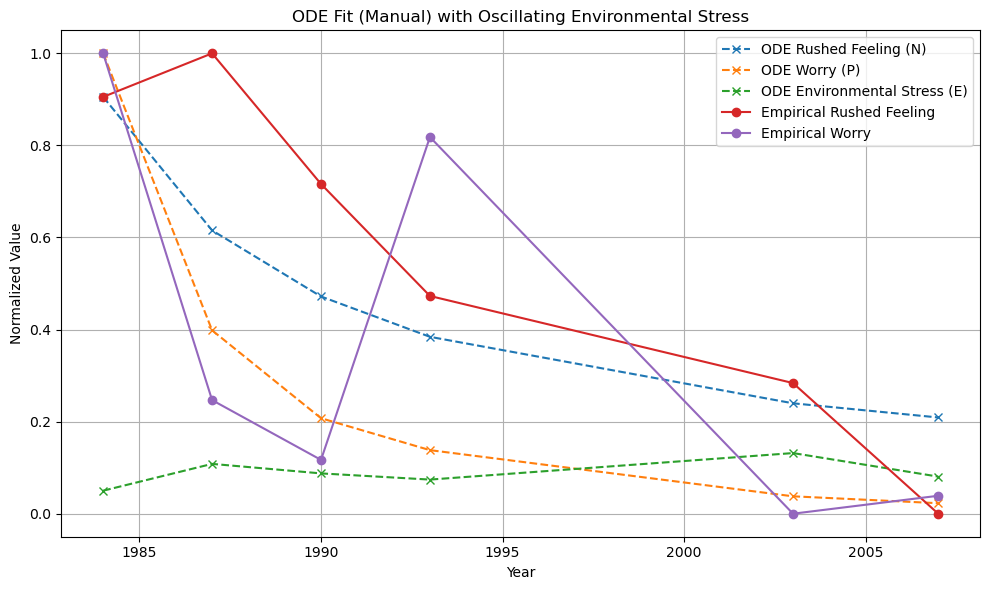

In [10]:
# ECTO Nonlinear ODE System
# Note: This module is able to run via L-BFGS-B Optimization, 
# or with Manual Parameter fitting (Manual default shown)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# Toggle: Use Optimizer or Manually Set Parameters
use_optimizer = False  # <<< Set to False to manually adjust c3 and others

# Trait Entropy Data (Import Likert-cum-entropy Data): 
data = {
    "Year": [1984, 1987, 1990, 1993, 2003, 2007],
    "Worry": [2.181, 2.123, 2.113, 2.167, 2.104, 2.107],
    "Curiosity": [2.162, 2.168, 2.148, 2.178, 2.146, 2.127],
    "Fulfillment": [2.206, 2.151, 2.140, 2.139, 2.106, 2.089],
    "Hot-Tempered": [2.075515, 2.001416, 2.021902, 1.997771, 1.897984, 1.955553],
    "Satisfaction": [2.025961, 1.955851, 1.978332, 1.995150, 1.710238, 1.728416],
    "Indignant": [2.248145, 2.218126, 2.219295, 2.237407, 2.202507, 2.186655],
    "Depressed": [1.954863, 1.890236, 1.911049, 1.950277, 1.852584, 1.876430],
    "Excitement Preference": [2.240, 2.167, 2.128, 2.127, 2.095, 2.019],
    "Impulsivity": [2.198, 2.180, 2.197, 2.206, 2.148, 2.102],
    "Competitive Ambition": [1.975, 1.860, 1.902, 1.965, 1.965, 1.994],
    "Life Optimism": [2.166, 2.097, 2.053, 2.029, 1.988, 1.993],
    "Rushed Feeling": [2.269, 2.276, 2.255, 2.237, 2.223, 2.202],
}
df = pd.DataFrame(data)

trait_x = "Rushed Feeling"
trait_y = "Worry"

years = np.array(df["Year"])
t_data = years - years[0]

def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

N_empirical = normalize(df[trait_x].values)
P_empirical = normalize(df[trait_y].values)

# ODE System with Oscillating E (E can be flattened or perturbed as appropriate):
def system(y, t, mu, beta, gamma, c1, c2, c3, K):
    N, P, E = y
    omega = 0.8
    amplitude = 0.05
    E_dynamic = c1 * P + c2 * N + c3 * E
    dNdt = mu * N - 0.15 * N**2 - beta**2 * N * P
    dPdt = mu * P - beta * P * E_dynamic
    dEdt = gamma * E * (N / (N + K)) + amplitude * 0.5 * np.sin(omega * t)
    return [dNdt, dPdt, dEdt]

# Initial Conditions:
init_conditions = [N_empirical[0], P_empirical[0], 0.05]

# Objective Function:
def objective(params):
    mu, beta, gamma, c1, c2, c3, K = params
    sol = odeint(system, init_conditions, t_data, args=(mu, beta, gamma, c1, c2, c3, K))
    error_N = np.sum((sol[:, 0] - N_empirical)**2)
    error_P = np.sum((sol[:, 1] - P_empirical)**2)
    return error_N + error_P

# Choose Parameters:
if use_optimizer:
    initial_guess = [0.0002, 0.2, 0.03, 1.0, 0.45, 0.3, 0.5]
    bounds = [
        (1e-5, 0.01), (0.01, 0.5), (0.01, 0.5),
        (0.21, 2.0), (0.21, 2.0), (0.01, 2.0), (0.21, 2.0)
    ]
    result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
    mu, beta, gamma, c1, c2, c3, K = result.x
else:
    # MANUAL PARAMETER EXPLORATION (this will engage when 'Use Optimizer' is set to 'FALSE'): 
    mu    = 0.00001
    beta  = 0.16746
    gamma = 0.03
    c1    = 2.0
    c2    = 0.21
    c3    = 05.60   # << Try changing this to see effect of E_stress feedback!
    K     = 0.5

# Simulate System:
sol = odeint(system, init_conditions, t_data, args=(mu, beta, gamma, c1, c2, c3, K))
N_model, P_model, E_model = sol.T

# Validation:
rmse_N = np.sqrt(mean_squared_error(N_empirical, N_model))
rmse_P = np.sqrt(mean_squared_error(P_empirical, P_model))
r2_N = r2_score(N_empirical, N_model)
r2_P = r2_score(P_empirical, P_model)

# Shape Metrics:
# DTW function:
def dtw_distance(a, b):
    n, m = len(a), len(b)
    D = np.full((n+1, m+1), np.inf)
    D[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(a[i-1] - b[j-1])
            D[i, j] = cost + min(D[i-1, j], D[i, j-1], D[i-1, j-1])
    return D[n, m]

rN, pN = pearsonr(N_empirical, N_model)
rP, pP = pearsonr(P_empirical, P_model)
dtwN = dtw_distance(N_empirical, N_model)
dtwP = dtw_distance(P_empirical, P_model)

# === Output ===
print(f"\n{'Optimized' if use_optimizer else 'Manual'} Parameters:")
print(f"mu = {mu:.5f}, beta = {beta:.5f}, gamma = {gamma:.5f}, c1 = {c1:.5f}, c2 = {c2:.5f}, c3 = {c3:.5f}, K = {K:.5f}")
print(f"\nValidation Metrics:")
print(f"RMSE for {trait_x}: {rmse_N:.4f}")
print(f"RMSE for {trait_y}: {rmse_P:.4f}")
print(f"R² for {trait_x}: {r2_N:.4f}")
print(f"R² for {trait_y}: {r2_P:.4f}")
print(f"Pearson r (N): {rN:.3f} (p={pN:.3f})")
print(f"Pearson r (P): {rP:.3f} (p={pP:.3f})\n")
print(f"DTW distance (N): {dtwN:.3f}")
print(f"DTW distance (P): {dtwP:.3f}")

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(years, N_model, 'x--', label=f'ODE {trait_x} (N)')
plt.plot(years, P_model, 'x--', label=f'ODE {trait_y} (P)')
plt.plot(years, E_model, 'x--', label='ODE Environmental Stress (E)')
plt.plot(years, N_empirical, 'o-', label=f'Empirical {trait_x}')
plt.plot(years, P_empirical, 'o-', label=f'Empirical {trait_y}')
plt.title(f"ODE Fit ({'Optimized' if use_optimizer else 'Manual'}) with Oscillating Environmental Stress")
plt.xlabel("Year")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


R² min (N): 0.603
R² max (N): 0.664 at α = 0.010, β = 0.120
R² mean (N): 0.636 ± 0.019
400/400 combinations had R² (N) > 0.5 (100.0%)
R² min (P): 0.402
R² max (P): 0.490 at α = 0.010, β = 0.120
R² mean (P): 0.449 ± 0.028
0/400 combinations had R² (P) > 0.5 (0.0%)


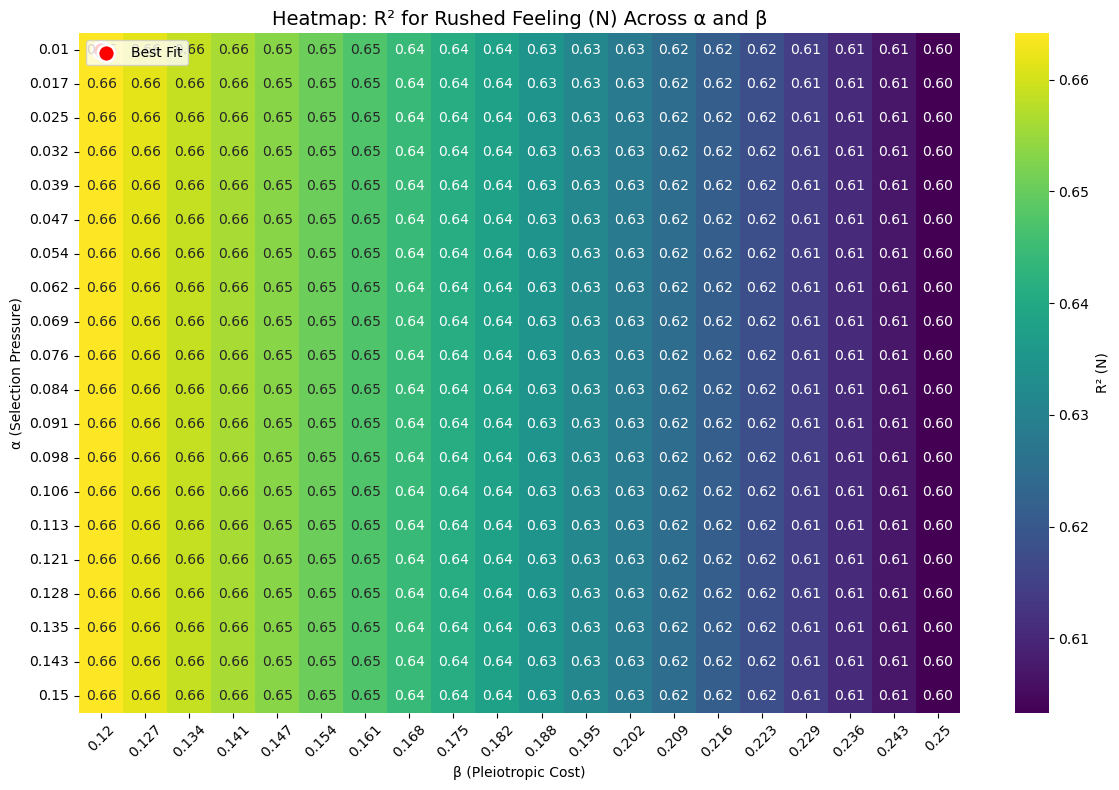

In [12]:
import seaborn as sns
import pandas as pd


# Sweep alpha and beta
alpha_values = np.linspace(0.01, 0.15, 20)  # α = selection cost
beta_values = np.linspace(0.12, 0.25, 20)   # β = pleiotropic penalty

r2_results_N = np.zeros((len(alpha_values), len(beta_values)))
r2_results_P = np.zeros((len(alpha_values), len(beta_values)))
rmse_results_N = np.zeros_like(r2_results_N)
rmse_results_P = np.zeros_like(r2_results_P)

# Fixed parameters
mu = 0.00001
gamma = 0.03
c1 = 2.0
c2 = 0.21
c3 = 5.60  # ← Environmental stress term: unperturbed
K = 0.5

# Updated ODE to use alpha dynamically
def system_sweep(y, t, mu, alpha, beta, gamma, c1, c2, c3, K):
    N, P, E = y
    omega = 0.8
    amplitude = 0.05
    E_dynamic = c1 * P + c2 * N + c3 * E
    dNdt = mu * N - 0.15 * N**2 - beta**2 * N * P
    dPdt = mu * P - beta * P * E_dynamic
    dEdt = gamma * E * (N / (N + K)) + amplitude * 0.5 * np.sin(omega * t)
    return [dNdt, dPdt, dEdt]

# Perform sweep
for i, alpha in enumerate(alpha_values):
    for j, beta in enumerate(beta_values):
        sol = odeint(system_sweep, init_conditions, t_data, args=(mu, alpha, beta, gamma, c1, c2, c3, K))
        N_model, P_model, _ = sol.T

        r2_results_N[i, j] = r2_score(N_empirical, N_model)
        r2_results_P[i, j] = r2_score(P_empirical, P_model)
        rmse_results_N[i, j] = np.sqrt(mean_squared_error(N_empirical, N_model))
        rmse_results_P[i, j] = np.sqrt(mean_squared_error(P_empirical, P_model))

alpha_labels = [round(a, 3) for a in alpha_values]
beta_labels = [round(b, 3) for b in beta_values]

r2_df_N = pd.DataFrame(r2_results_N, index=alpha_labels, columns=beta_labels)

plt.figure(figsize=(12, 8))
ax = sns.heatmap(r2_df_N, annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'R² (N)'})
plt.title("Heatmap: R² for Rushed Feeling (N) Across α and β", fontsize=14)
plt.xlabel("β (Pleiotropic Cost)")
plt.ylabel("α (Selection Pressure)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Optional: Highlight best value
max_idx = np.unravel_index(np.argmax(r2_results_N), r2_results_N.shape)
best_alpha = alpha_labels[max_idx[0]]
best_beta = beta_labels[max_idx[1]]
plt.scatter(x=max_idx[1]+0.5, y=max_idx[0]+0.5, s=150, c="red", edgecolors="white", linewidth=2, label="Best Fit")
plt.legend(loc="upper left")

# Flatten for analysis N trait
r2_flat = r2_results_N.flatten()

# Basic statistics
r2_min = np.min(r2_flat)
r2_max = np.max(r2_flat)
r2_mean = np.mean(r2_flat)
r2_std = np.std(r2_flat)

# Best parameter combo
best_idx = np.unravel_index(np.argmax(r2_results_N), r2_results_N.shape)
best_alpha = alpha_values[best_idx[0]]
best_beta = beta_values[best_idx[1]]
best_r2 = r2_results_N[best_idx]

# Count how many parameter sets exceed a threshold (e.g., R² > 0.5)
threshold = 0.5
num_above_thresh = np.sum(r2_results_N > threshold)
total_tests = r2_results_N.size
percent_above = 100 * num_above_thresh / total_tests

# Report
print(f"R² min (N): {r2_min:.3f}")
print(f"R² max (N): {r2_max:.3f} at α = {best_alpha:.3f}, β = {best_beta:.3f}")
print(f"R² mean (N): {r2_mean:.3f} ± {r2_std:.3f}")
print(f"{num_above_thresh}/{total_tests} combinations had R² (N) > {threshold} ({percent_above:.1f}%)")

# Flatten for P (Worry)
r2_flat_P = r2_results_P.flatten()

# Basic stats for P
r2_min_P = np.min(r2_flat_P)
r2_max_P = np.max(r2_flat_P)
r2_mean_P = np.mean(r2_flat_P)
r2_std_P = np.std(r2_flat_P)

# Best (α, β) for P
best_idx_P = np.unravel_index(np.argmax(r2_results_P), r2_results_P.shape)
best_alpha_P = alpha_values[best_idx_P[0]]
best_beta_P = beta_values[best_idx_P[1]]
best_r2_P = r2_results_P[best_idx_P]

# Threshold count
threshold = 0.5
num_above_P = np.sum(r2_results_P > threshold)
total_tests = r2_results_P.size
percent_above_P = 100 * num_above_P / total_tests

# Print
print(f"R² min (P): {r2_min_P:.3f}")
print(f"R² max (P): {r2_max_P:.3f} at α = {best_alpha_P:.3f}, β = {best_beta_P:.3f}")
print(f"R² mean (P): {r2_mean_P:.3f} ± {r2_std_P:.3f}")
print(f"{num_above_P}/{total_tests} combinations had R² (P) > {threshold} ({percent_above_P:.1f}%)")


plt.tight_layout()
plt.show()


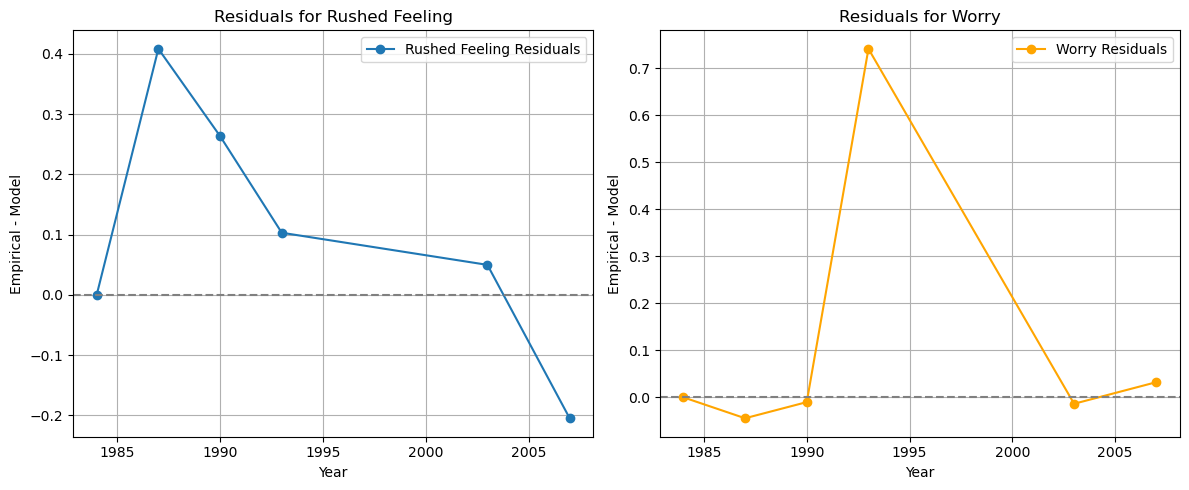


Residual Summary for Rushed Feeling:
  Mean: 0.1035
  Std Dev: 0.1946
  Max: 0.4085
  Min: -0.2046
  Skewness: 0.0452
  Kurtosis: -0.8556
  Shapiro-Wilk Normality Test p-value: 0.9715 (normal)

Residual Summary for Worry:
  Mean: 0.1175
  Std Dev: 0.2798
  Max: 0.7411
  Min: -0.0445
  Skewness: 1.7629
  Kurtosis: 1.1534
  Shapiro-Wilk Normality Test p-value: 0.0002 (non-normal)


In [13]:
from scipy.stats import shapiro, skew, kurtosis

# Calculate Residuals
residuals_N = N_empirical - N_model
residuals_P = P_empirical - P_model

# Plot Residuals
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(years, residuals_N, 'o-', label=f'{trait_x} Residuals')
plt.axhline(0, color='gray', linestyle='--')
plt.title(f'Residuals for {trait_x}')
plt.xlabel("Year")
plt.ylabel("Empirical - Model")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(years, residuals_P, 'o-', color='orange', label=f'{trait_y} Residuals')
plt.axhline(0, color='gray', linestyle='--')
plt.title(f'Residuals for {trait_y}')
plt.xlabel("Year")
plt.ylabel("Empirical - Model")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Residuals
residuals_N = N_empirical - N_model
residuals_P = P_empirical - P_model

# Summary Statistics
def summarize_residuals(residuals, label):
    print(f"\nResidual Summary for {label}:")
    print(f"  Mean: {np.mean(residuals):.4f}")
    print(f"  Std Dev: {np.std(residuals):.4f}")
    print(f"  Max: {np.max(residuals):.4f}")
    print(f"  Min: {np.min(residuals):.4f}")
    print(f"  Skewness: {skew(residuals):.4f}")
    print(f"  Kurtosis: {kurtosis(residuals):.4f}")
    _, p_val = shapiro(residuals)
    print(f"  Shapiro-Wilk Normality Test p-value: {p_val:.4f} {'(non-normal)' if p_val < 0.05 else '(normal)'}")

# Run Summary
summarize_residuals(residuals_N, trait_x)
summarize_residuals(residuals_P, trait_y)

